In [3]:
import pandas as pd
import os
import cv2
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

from skimage import transform, exposure, restoration, feature, filters
from skimage.restoration import denoise_tv_chambolle
from skimage.util import view_as_windows

In [4]:
def clip_intensity(img, clip_limit=None, clip_value=None):
    # Clip image intensities
    
    if clip_limit is None:
        clip_limit = np.quantile(img.flatten(), 0.985)

    if clip_value is None:
        clip_value=clip_limit     

    clipped_img = np.clip(img, 0, clip_limit)
    clipped_img[clipped_img == clip_limit] = clip_value
    return clipped_img


def clahe(img, clip_limit_clahe=None, kernel_size=None, nbins=256):
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    if clip_limit_clahe is None:
        clip_limit_clahe = .01
    
    if kernel_size is None:
        kernel_size = img.shape[0]//10 
        
    clahe = exposure.equalize_adapthist(img, clip_limit=clip_limit_clahe, kernel_size=kernel_size, nbins=nbins)
    return clahe
    average_angle = compute_average_angle(frames_for_angle, use_structure_tensor)

def denoise_image(img,weight=0.02):
    # Apply denoising using TV
    denoised_img = denoise_tv_chambolle(img,weight)
    return denoised_img

def pad_image(image):
    padded_image = np.pad(image, ((0, 4), (0, 0)), mode='constant')
    return padded_image


def scale_image(image):
    # Determine the minimum and maximum values of the image
    min_val = np.min(image)
    max_val = np.max(image)
    
    # Scale the image to the range [0, 1]
    scaled_image = (image - min_val) / (max_val - min_val)
    
    return scaled_image

def preprocess_channel(channel):
    # Clip intensity values
    channel = clip_intensity(channel)
    
    # Denoise using TV Chambolle
    channel = denoise_tv_chambolle(channel)
    
    # Scale the image
    channel = scale_image(channel).astype(np.float32)

    # channel = pad_image(channel)
    # channel[channel < 0.07] = 0
    # threshold = filters.threshold_otsu(channel)

    # binary_image = channel > threshold
    # channel[binary_image == 0] = 0
    
    return channel
    

def read_images_and_save(row, experiment_name="cancer"):
    exp_id = row['Date fixation (Exp ID)']
    teh_pattern = row['Pattern utilisé (T-E-H)'].replace(',', '-')
    cell_type = row['Cellules']
    directory_path = os.path.join("../database/", experiment_name, str(exp_id), f'TEH_{teh_pattern}', cell_type)
    images = []
    for index, filename in enumerate(os.listdir(directory_path)):
        if filename.endswith('.tif'):
            image_path = os.path.join(directory_path, filename)
            image = imageio.imread(image_path)  # Reading image using OpenCV
            intensity_values = np.array(image[1])
            intensity_values = preprocess_channel(intensity_values)
            # preprocessed_channels = []
            # for i in range(intensity_values.shape[0]):
            #     preprocessed_channel = preprocess_channel(intensity_values[i])
            #     preprocessed_channels.append(preprocessed_channel)
            # preprocessed_image = np.stack(preprocessed_channels, axis=-1)
            # intensity_values = preprocessed_image.astype(np.float32)
            
            # Saving image
            save_directory = os.path.join("./data", experiment_name, "original", cell_type)
            os.makedirs(save_directory, exist_ok=True)
            save_path = os.path.join(save_directory, f"{exp_id}_{cell_type}_{teh_pattern}_{index}.npy")
            np.save(save_path, intensity_values)
            #imageio.imwrite(os.path.join(save_directory, f"{exp_id}_{cell_type}_{index}.tif"), intensity_values)

            #class_mapping = {'WT': 0, 'K32': 1, 'L380S': 2, 'R249W': 3, "Nesprin1KO": 4}  # Define mapping of cell types to class values
            class_mapping = {'MCF10A': 0, 'BRAF': 1, 'DCIS.com': 2, 'PIK3CA H': 3, 'Rac1': 4}
            #class_mapping = {'WT': 0}
            #class_mapping = {'MCF10A': 0, }
            images.append((exp_id, f"{exp_id}_{cell_type}_{teh_pattern}_{index}", save_path, class_mapping.get(cell_type, 1)))

    return images

In [5]:
df = pd.read_excel("../database/datasheet.xlsx", sheet_name="Cancer Mutations")

In [12]:
experiment_data = df[(
                      (df['Pattern utilisé (T-E-H)'] == '5,9,7.6') | 
                      (df['Pattern utilisé (T-E-H)'] == '5,7,7.6') |
                      (df['Pattern utilisé (T-E-H)'] == '5,8,7.6')| 
                      (df['Pattern utilisé (T-E-H)'] == '5,6,7.6')| 
                      (df['Pattern utilisé (T-E-H)'] == '5,5,7.6')) & (df['Marquages'].str.contains("Lamin AC"))] # & ((df['Cellules'] == "WT") | (df['Cellules'] == "K32"))]

In [13]:
experiment_data

,Date fixation (Exp ID),Pattern utilisé (T-E-H),Cellules,Densité départ,Temps de culture,Marquages,Number of images
0,220429,"5,5,7.6",BRAF,150000,27,Lamin AC (G) / Phallo (Red) / Fibro (FR),8
1,220429,"5,5,7.6",DCIS.com,150000,27,Lamin AC (G) / Phallo (Red) / Fibro (FR),3
2,220429,"5,5,7.6",MCF10A,150000,27,Lamin AC (G) / Phallo (Red) / Fibro (FR),6
3,220429,"5,5,7.6",PIK3CA H,150000,27,Lamin AC (G) / Phallo (Red) / Fibro (FR),5
4,220429,"5,5,7.6",Rac1,150000,27,Lamin AC (G) / Phallo (Red) / Fibro (FR),5
...,...,...,...,...,...,...,...
80,220508,"5,9,7.6",BRAF,150000,27,Lamin AC (G) / Phallo (Red) / Fibro (FR),6
81,220508,"5,9,7.6",DCIS.com,150000,27,Lamin AC (G) / Phallo (Red) / Fibro (FR),5
82,220508,"5,9,7.6",MCF10A,150000,27,Lamin AC (G) / Phallo (Red) / Fibro (FR),6
83,220508,"5,9,7.6",PIK3CA H,150000,27,Lamin AC (G) / Phallo (Red) / Fibro (FR),6


In [14]:
train_images = sum(experiment_data.apply(read_images_and_save, experiment_name="cancer", axis=1), [])
train_df = pd.DataFrame(train_images, columns=['Exp ID','original ID', 'path', 'class'])
train_df.to_csv('./data/cancer/data.csv', index=False)

## Create cropped data for experiments

In [15]:
myoblast_df = pd.read_csv('./data/cancer/data.csv')

In [16]:
def generate_sliding_windows(input_file, df, row):
    # Load the input image
    image = np.load(input_file)
    
    # Define sliding window parameters
    window_size = (1024, 1024)
    stride = 511 # 20% overlap    
    
    # Generate sliding windows
    windows = view_as_windows(image, window_size, stride)

    output_dir = os.path.dirname(input_file.replace("original", "cropped"))
    os.makedirs(output_dir, exist_ok=True)

    original_filename = os.path.basename(input_file)
    filename_no_ext, ext = os.path.splitext(original_filename)
    
    # Save each sliding window as a separate image
    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            window = windows[i, j]
            # Generate filename for the window
            filename = os.path.join(output_dir, f"{filename_no_ext}_window_{i}_{j}.npy")
            # Save the window as a numpy file
            np.save(filename, window)
            new_row = {"Exp ID": row["Exp ID"], "original ID": row["original ID"], "path": filename, "class": row["class"]}
            df = df._append(new_row, ignore_index=True)
            
    return df

def generate_sliding_windows_from_dataframe(df):
    res_df = pd.DataFrame()
    for index, row in df.iterrows():
        input_file = row['path']
        res_df = generate_sliding_windows(input_file, res_df, row)
    return res_df

In [17]:
res_df = generate_sliding_windows_from_dataframe(myoblast_df)
res_df.to_csv('./data/cancer/data_cropped.csv', index=False)

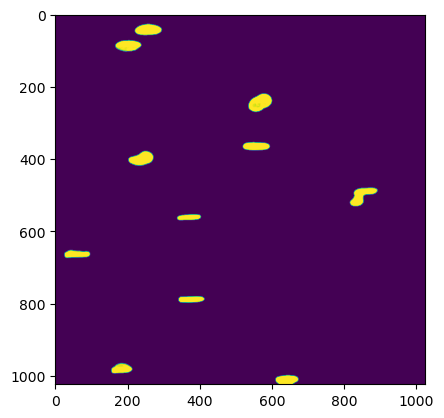

In [79]:
image = np.load("./data/fibroblast/cropped/Lipo/240215_Lipo_5-5-5.4_0_window_0_1.npy")
plt.imshow(image)

In [34]:
print(image)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
histogram, bins = np.histogram(image.flatten(), bins=1000, range=(0,1))

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")
plt.hist(image.flatten(), bins=256, range=(0,1), color='black')
plt.xlim([0, 1])
plt.show()

In [ ]:
image = np.load("./data/myoblast/original/WT/210929_WT_5-5-4_0.npy")
plt.imshow(image)